## Load the Packages 

In [123]:
%pip install gurobipy
!pip install numpy pandas scikit-learn xgboost tensorflow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: gurobipy in c:\users\sayan\appdata\local\programs\python\python310\lib\site-packages (12.0.3)




[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [124]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import tree 
import seaborn as sns
import sklearn 
import numpy as np  

## Load the Datasets

There are eight large regions, namely the Great Lakes, Midsouth, North East, Northern New England, South Central, South East, West and Plains.

In [125]:
avocado = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/HABdata_2019_2022.csv') # dataset downloaded directly from HAB
avocado.head()

,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69


In [126]:
avocado_old = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/kaggledata_till2018.csv') # dataset downloaded from Kaggle
avocado_old.head()

,region,date,type,price,units_sold
0,Great_Lakes,1/4/15,Conventional,1.02,3382800.12
1,Great_Lakes,1/4/15,Organic,1.54,61615.10
2,Great_Lakes,1/11/15,Conventional,1.10,3067638.32
3,Great_Lakes,1/11/15,Organic,1.69,58061.65
4,Great_Lakes,1/18/15,Conventional,1.08,3006207.02


In [127]:
avocado = pd.concat([avocado, avocado_old], ignore_index=True)
avocado.head()

,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69


## Data Pre-processing

Handling missing values

Removing duplicates

Encoding categorical variables

Normalizing or scaling numerical features

Splitting data into train/test sets

Feature extraction or selection

In [128]:
avocado["date"]=pd.to_datetime(avocado["date"])
avocado.head()

,region,date,type,price,units_sold
0,Great_Lakes,2019-01-07,Conventional,1.106743,3812441.96
1,Great_Lakes,2019-01-07,Organic,1.371280,275987.52
2,Great_Lakes,2019-01-13,Conventional,1.063457,3843318.68
3,Great_Lakes,2019-01-13,Organic,1.493384,244991.95
4,Great_Lakes,2019-01-20,Conventional,1.049931,4587957.69


In [129]:
avocado["year"]=pd.DatetimeIndex(avocado["date"]).year
avocado.head()

,region,date,type,price,units_sold,year
0,Great_Lakes,2019-01-07,Conventional,1.106743,3812441.96,2019
1,Great_Lakes,2019-01-07,Organic,1.371280,275987.52,2019
2,Great_Lakes,2019-01-13,Conventional,1.063457,3843318.68,2019
3,Great_Lakes,2019-01-13,Organic,1.493384,244991.95,2019
4,Great_Lakes,2019-01-20,Conventional,1.049931,4587957.69,2019


In [130]:
avocado["year"].unique()

array([2019, 2020, 2021, 2022, 2015, 2016, 2017, 2018], dtype=int32)

In [131]:
avocado["year_index"]=avocado["year"]-2015
avocado.head()

,region,date,type,price,units_sold,year,year_index
0,Great_Lakes,2019-01-07,Conventional,1.106743,3812441.96,2019,4
1,Great_Lakes,2019-01-07,Organic,1.371280,275987.52,2019,4
2,Great_Lakes,2019-01-13,Conventional,1.063457,3843318.68,2019,4
3,Great_Lakes,2019-01-13,Organic,1.493384,244991.95,2019,4
4,Great_Lakes,2019-01-20,Conventional,1.049931,4587957.69,2019,4


In [132]:
avocado=avocado.sort_values(by="date")
avocado.head(3)

,region,date,type,price,units_sold,year,year_index
3096,Great_Lakes,2015-01-04,Conventional,1.02,3382800.12,2015,0
3508,Midsouth,2015-01-04,Conventional,1.10,2578275.12,2015,0
6392,West,2015-01-04,Conventional,0.89,5794410.58,2015,0


Define the peak season

In [133]:

avocado["month"]=pd.DatetimeIndex(avocado["date"]).month
avocado.head(2)

,region,date,type,price,units_sold,year,year_index,month
3096,Great_Lakes,2015-01-04,Conventional,1.02,3382800.12,2015,0,1
3508,Midsouth,2015-01-04,Conventional,1.10,2578275.12,2015,0,1


In [134]:
peak_months = range(2,8)        # <--------- Set the months for the "peak season"
def peak_season(row):
    return 1 if int(row['month']) in peak_months else 0  


avocado['peak'] = avocado.apply(lambda row: peak_season(row), axis=1)
avocado.head()

,region,date,type,price,units_sold,year,year_index,month,peak
3096,Great_Lakes,2015-01-04,Conventional,1.02,3382800.12,2015,0,1,0
3508,Midsouth,2015-01-04,Conventional,1.10,2578275.12,2015,0,1,0
6392,West,2015-01-04,Conventional,0.89,5794410.58,2015,0,1,0
6393,West,2015-01-04,Organic,1.40,187548.30,2015,0,1,0
5569,Southeast,2015-01-04,Organic,1.75,27365.89,2015,0,1,0


In [135]:
# Scale the number of avocados to millions
avocado['units_sold'] = avocado['units_sold']/1000000

# Select only conventional avocados
avocado = avocado[avocado['type'] == 'Conventional'] 
avocado.head()

,region,date,type,price,units_sold,year,year_index,month,peak
3096,Great_Lakes,2015-01-04,Conventional,1.02,3.382800,2015,0,1,0
3508,Midsouth,2015-01-04,Conventional,1.10,2.578275,2015,0,1,0
6392,West,2015-01-04,Conventional,0.89,5.794411,2015,0,1,0
5568,Southeast,2015-01-04,Conventional,0.98,3.204112,2015,0,1,0
4332,Northern_New_England,2015-01-04,Conventional,1.05,0.321824,2015,0,1,0


In [136]:
avocado = avocado[['date','units_sold','price','region','year','month','year_index','peak']].reset_index(drop = True)
avocado

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0,0
...,...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,7,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,7,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,7,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,7,1


In [137]:
avocado["region"].unique()

array(['Great_Lakes', 'Midsouth', 'West', 'Southeast',
       'Northern_New_England', 'Total_US', 'Northeast', 'SouthCentral',
       'Plains'], dtype=object)

## Part 1: Observe Trends in the Data

Now, we will infer sales trends in time and seasonality. For simplicity, let's proceed with data from the United States as a whole.

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import layers, models


In [139]:
df_Total_US=avocado[avocado["region"]=="Total_US"]
df_Total_US.head()

,date,units_sold,price,region,year,month,year_index,peak
5,2015-01-04,31.324278,0.95,Total_US,2015,1,0,0
14,2015-01-11,29.063543,1.01,Total_US,2015,1,0,0
21,2015-01-18,29.043459,1.03,Total_US,2015,1,0,0
34,2015-01-25,28.470311,1.04,Total_US,2015,1,0,0
44,2015-02-01,44.655462,0.89,Total_US,2015,2,0,1


#### Sales Over the Years

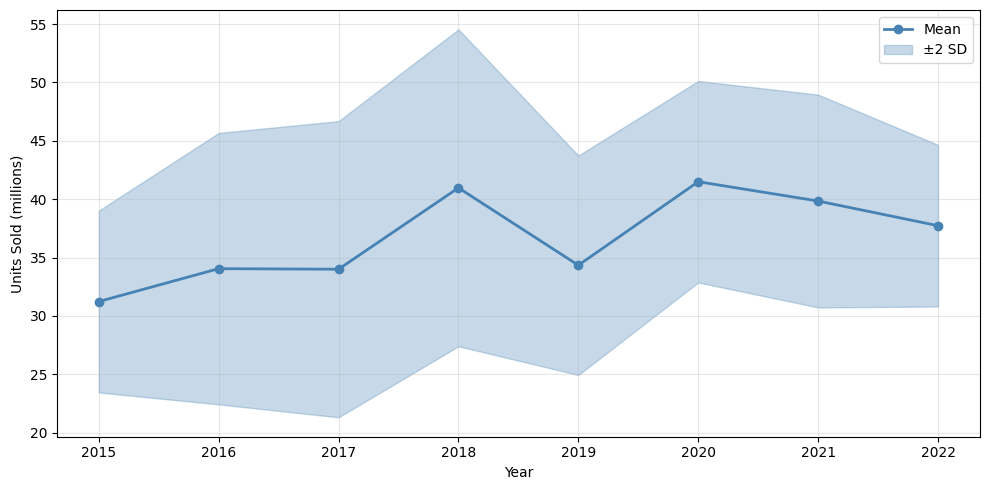

In [140]:
fig, ax = plt.subplots(figsize=(10, 5))

mean = df_Total_US.groupby("year")['units_sold'].mean()
std = df_Total_US.groupby("year")["units_sold"].std()

ax.plot(mean.index, mean, marker='o', linewidth=2, color='steelblue', label='Mean')
ax.fill_between(mean.index, mean - 2*std, mean + 2*std, 
                 alpha=0.3, color='steelblue', label='±2 SD')
ax.set_ylabel('Units Sold (millions)')
ax.set_xlabel('Year')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The Combined Box + Swarm Plot is a powerful visualization that layers two plot types together to show both summary statistics and individual data points simultaneously.

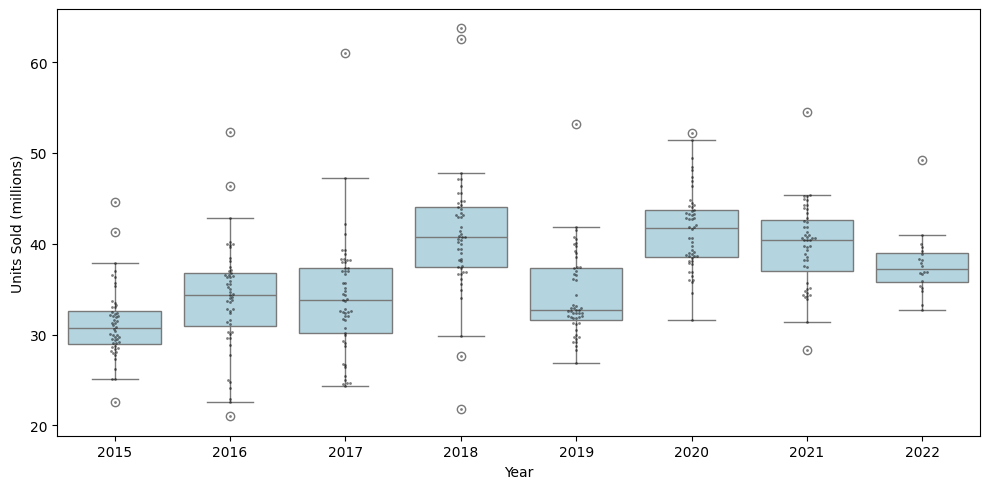

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df_Total_US, x='year', y='units_sold', ax=ax, color='lightblue')
sns.swarmplot(data=df_Total_US, x='year', y='units_sold', ax=ax, 
              color='black', alpha=0.5, size=2)
ax.set_ylabel('Units Sold (millions)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.show()

## Seasonality

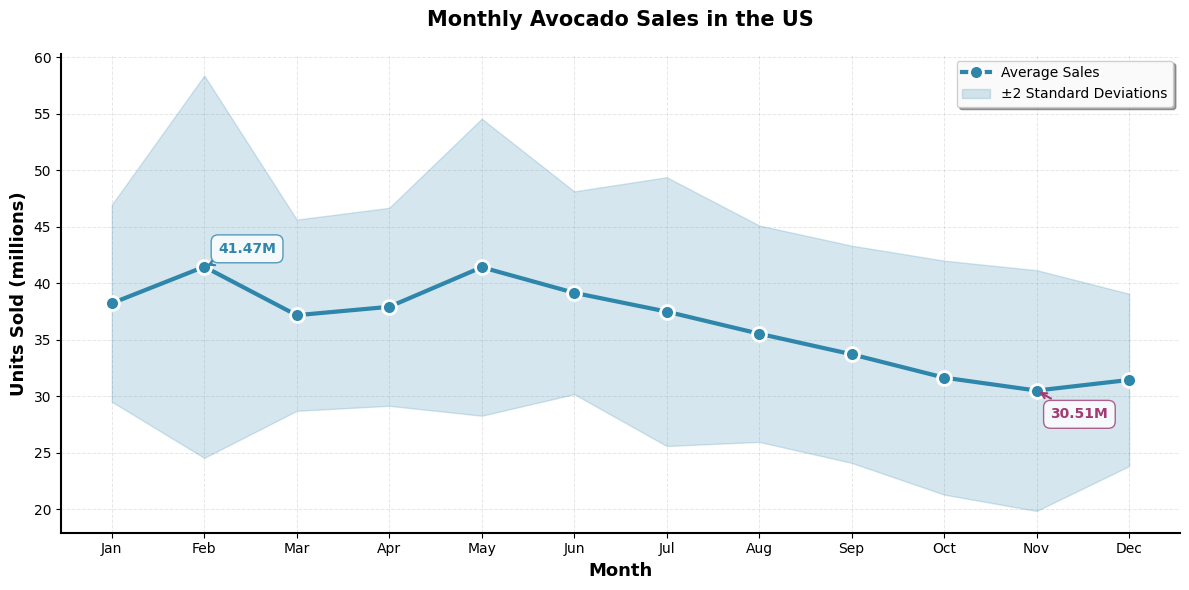

In [142]:
fig, ax = plt.subplots(figsize=(12, 6))

mean = df_Total_US.groupby('month')['units_sold'].mean()
std = df_Total_US.groupby('month')['units_sold'].std()

# Main line with gradient effect
ax.plot(mean.index, mean, marker='o', linewidth=3, 
        color='#2E86AB', markersize=10, markeredgecolor='white', 
        markeredgewidth=2, label='Average Sales', zorder=3)

# Shaded confidence interval
ax.fill_between(mean.index, mean - 2*std, mean + 2*std, 
                alpha=0.2, color='#2E86AB', label='±2 Standard Deviations')

# Add subtle grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Styling
ax.set_ylabel('Units Sold (millions)', fontsize=13, fontweight='bold')
ax.set_xlabel('Month', fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add value labels on peaks
max_idx = mean.idxmax()
min_idx = mean.idxmin()
ax.annotate(f'{mean[max_idx]:.2f}M', 
            xy=(max_idx, mean[max_idx]), 
            xytext=(10, 10), textcoords='offset points',
            fontsize=10, fontweight='bold', color='#2E86AB',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#2E86AB', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='#2E86AB', lw=1.5))

ax.annotate(f'{mean[min_idx]:.2f}M', 
            xy=(min_idx, mean[min_idx]), 
            xytext=(10, -20), textcoords='offset points',
            fontsize=10, fontweight='bold', color='#A23B72',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#A23B72', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='#A23B72', lw=1.5))

# Legend
ax.legend(loc='best', framealpha=0.95, fontsize=10, shadow=True)

# Title
ax.set_title('Monthly Avocado Sales in the US', 
             fontsize=15, fontweight='bold', pad=20)

# Enhance spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

Two peack time in feb and Nov.

## Correlations

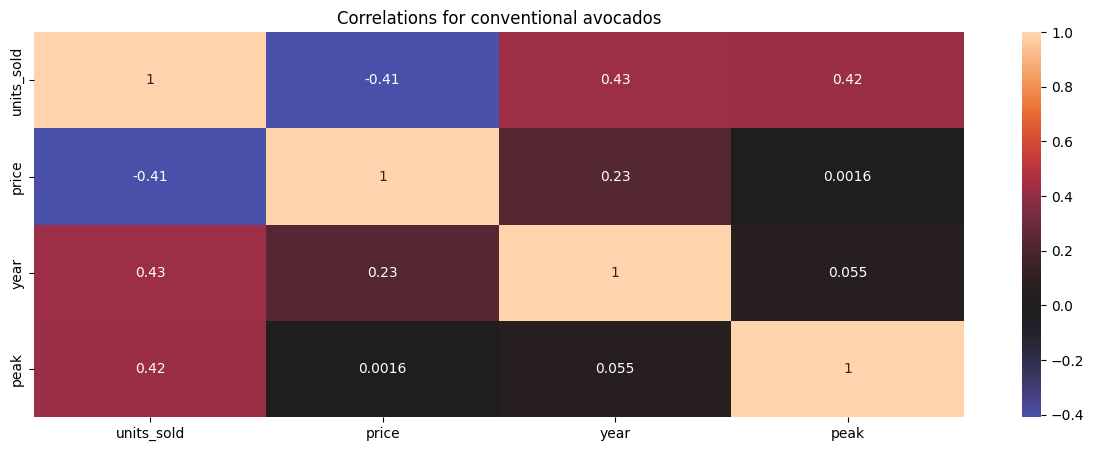

In [143]:
fig, axes =plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.heatmap(df_Total_US[["units_sold","price","year","peak"]].corr(),annot=True, center=0, ax=axes)

axes.set_title('Correlations for conventional avocados')
plt.show()

The sales quantity has a negative correlation with the price per avocado. The sales quantity has a positive correlation with the year and season being a peak season.

### Regions

Finally, we will see how the sales differ among the different regions. This will determine the number of avocados that we want to supply to each region.

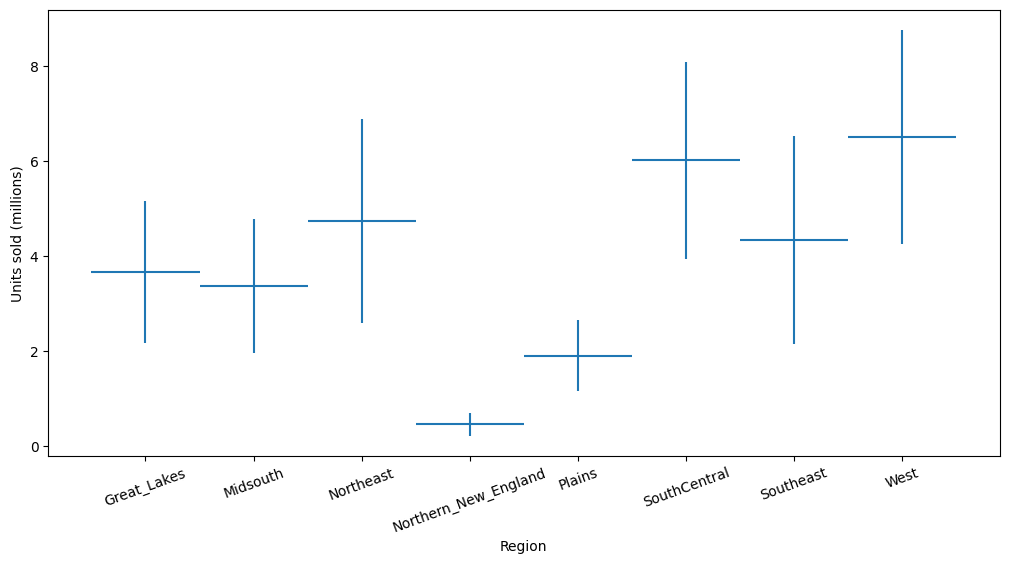

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) 

regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains'] 
df = avocado[avocado.region.isin(regions)]  

mean = df.groupby('region')['units_sold'].mean()
std  = df.groupby('region')['units_sold'].std() 
 
axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2*std, linestyle='')  

fig.tight_layout()
 
plt.xlabel('Region') 
plt.xticks(range(len(mean)), pd.DataFrame(mean)['units_sold'].index,rotation=20)
plt.ylabel('Units sold (millions)')
plt.show()

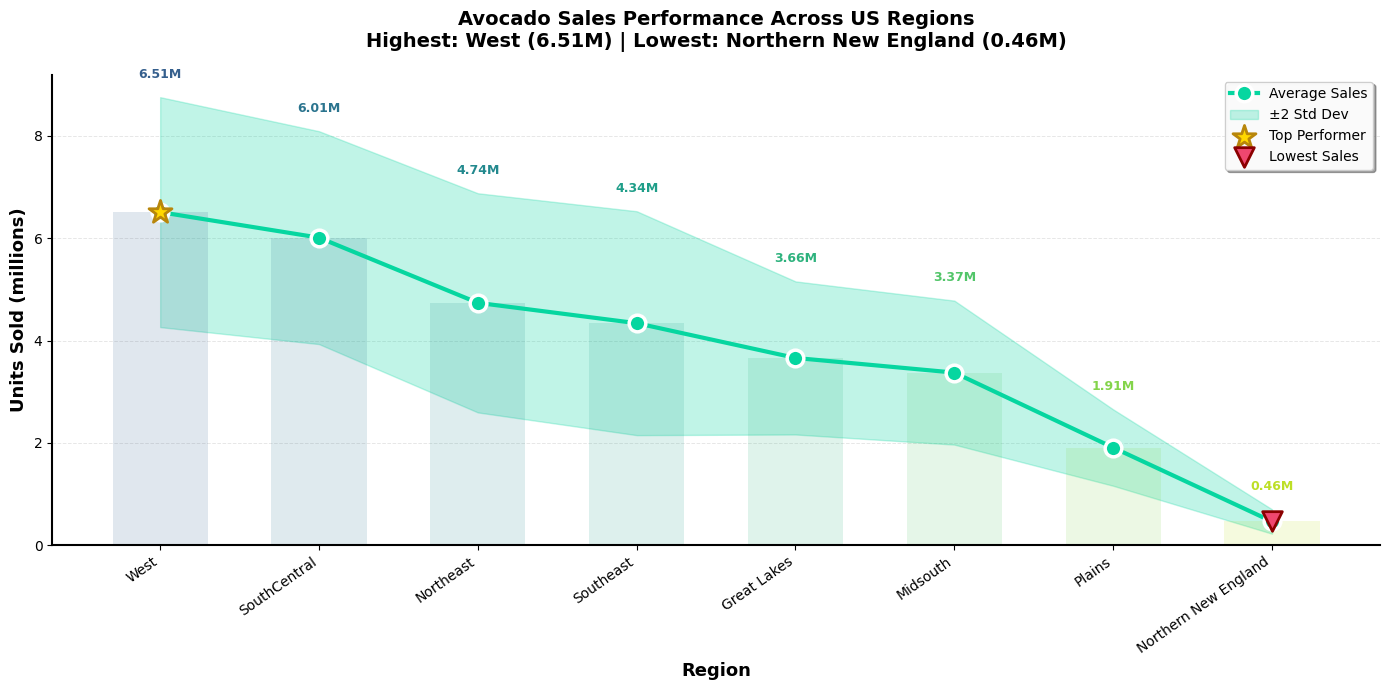

In [145]:

fig, ax = plt.subplots(figsize=(14, 7))

regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England',
           'SouthCentral','Southeast','West','Plains'] 
df = avocado[avocado.region.isin(regions)]  

mean = df.groupby('region')['units_sold'].mean()
std = df.groupby('region')['units_sold'].std()

# Sort by mean for better visual flow
mean_sorted = mean.sort_values(ascending=False)
std_sorted = std[mean_sorted.index]

# Create color gradient from high to low sales
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(mean_sorted)))

# Main line plot with markers
x_pos = np.arange(len(mean_sorted))
ax.plot(x_pos, mean_sorted.values, marker='o', linewidth=3, 
        color='#06D6A0', markersize=12, markeredgecolor='white', 
        markeredgewidth=2.5, zorder=3, label='Average Sales')

# Shaded confidence interval
ax.fill_between(x_pos, 
                mean_sorted.values - 2*std_sorted.values, 
                mean_sorted.values + 2*std_sorted.values, 
                alpha=0.25, color='#06D6A0', label='±2 Std Dev')

# Add colorful bars in background for context
for i, (region, value) in enumerate(mean_sorted.items()):
    ax.bar(i, value, alpha=0.15, color=colors[i], width=0.6, zorder=1)

# Add value labels on each point
for i, (region, value) in enumerate(mean_sorted.items()):
    ax.text(i, value + std_sorted[region]*2 + mean_sorted.max()*0.05, 
            f'{value:.2f}M',
            ha='center', va='bottom', fontsize=9, 
            fontweight='bold', color=colors[i])

# Styling
ax.set_ylabel('Units Sold (millions)', fontsize=13, fontweight='bold')
ax.set_xlabel('Region', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)

# Clean region names for labels
region_labels = [r.replace('_', ' ') for r in mean_sorted.index]
ax.set_xticklabels(region_labels, rotation=35, ha='right', fontsize=10)

# Add subtle grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax.set_axisbelow(True)

# Highlight top and bottom performers
top_region = mean_sorted.index[0]
bottom_region = mean_sorted.index[-1]

ax.scatter([0], [mean_sorted.iloc[0]], s=300, color='gold', 
           marker='*', zorder=4, edgecolors='darkgoldenrod', linewidths=2,
           label='Top Performer')
ax.scatter([len(mean_sorted)-1], [mean_sorted.iloc[-1]], s=200, 
           color='#EF476F', marker='v', zorder=4, edgecolors='darkred', linewidths=2,
           label='Lowest Sales')

# Legend
ax.legend(loc='upper right', framealpha=0.95, fontsize=10, shadow=True)

# Title with insights
ax.set_title('Avocado Sales Performance Across US Regions\n' + 
             f'Highest: {top_region.replace("_", " ")} ({mean_sorted.iloc[0]:.2f}M) | ' +
             f'Lowest: {bottom_region.replace("_", " ")} ({mean_sorted.iloc[-1]:.2f}M)',
             fontsize=14, fontweight='bold', pad=20)

# Enhance spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

west coaster has highes sales unit

## Part II:Predict the sales

The linear regressor can be mathematically expressed as:
### demand=β0​+β1​(price)+β2​(year_index)+β3​(region)+β4​(peak)+ϵ

Here, the $\beta$ values are weights (or "co-efficients") that have to be learned from the data. 
Note that the notation $\mathbb{1}(region)$ is an indicator function that takes the value $1$ for each region in the summation. The value of $\mathbb{1}(peak)$ is $1$ if we consider the peak season.


In [146]:
!pip install statsmodels


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [147]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

To validate the regression model, we will randomly split the dataset into $80\%$ training and $20\%$ testing data and learn the weights using sklearns. 

In [148]:
train, test =train_test_split(df, train_size=0.8, random_state=1)
df_train=pd.DataFrame(train, columns=df.columns)
df_test=pd.DataFrame(test, columns=df.columns)
df_train.head(2)

,date,units_sold,price,region,year,month,year_index,peak
2310,2019-12-22,0.328761,1.318248,Northern_New_England,2019,12,4,0
790,2016-09-04,6.802635,0.780000,SouthCentral,2016,9,1,0


C() stands for Categorical in statsmodels formulas.

In [149]:
formula='units_sold ~ price + year_index + C(region) + peak'
formula

'units_sold ~ price + year_index + C(region) + peak'

In [150]:
mod=smf.ols(formula, data=df_train)
result=mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             units_sold   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     2401.
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:13:20   Log-Likelihood:                -2271.1
No. Observations:                2419   AIC:                             4564.
Df Residuals:                    2408   BIC:                             4628.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             5.4500      0.092     59.538      0.000       5.271       5.630
C(region)[T.Midsouth]                -0.2199      0.050     -4.393      0.000      -0.318      -0.122
C(region)[T.Northeast]                1.4342      0.052     27.567      0.000       1.332       1.536
C(region)[T.Northern_New_England]    -3.0163      0.051    -59.425      0.000      -3.116      -2.917
C(region)[T.Plains]                  -1.8049      0.050    -35.848      0.000      -1.904      -1.706
C(region)[T.SouthCentral]             1.7175      0.054     31.522      0.000       1.611       1.824
C(region)[T.Southeast]                0.5889      0.050     11.739      0.000       0.491       0.687
C(region)[T.West]                     2.5969      0.051     50.639      0.000       2.496       2.697
price                                -2.1982      0.071    -30.938      0.000      -2.338      -2.059
year_index                            0.1560      0.006     26.509      0.000       0.144       0.168
peak                                  0.5289      0.025     20.915      0.000       0.479       0.578
==============================================================================
Omnibus:                      231.336   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.900
Skew:                           0.542   Prob(JB):                    6.59e-130
Kurtosis:                       5.174   Cond. No.                         40.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
# Get R^2 from test data
y_true = df_test['units_sold']
y_pred = result.predict(df_test)
print("The R^2 value in the test set is",r2_score(y_true, y_pred))

The R^2 value in the test set is 0.8982069358257863


In [152]:
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod_full = smf.ols(formula,data=df)
result_full = mod_full.fit()

y_true_full = df['units_sold']
y_pred_full = result_full.predict(df)
print("The R^2 value in the full dataset is",r2_score(y_true_full, y_pred_full))


The R^2 value in the full dataset is 0.9066729322212482


In [153]:
# Get the weights and store it
coef_dict = result_full.params.to_dict() 
coef_dict['C(region)[T.Great_Lakes]'] = 0 
coef_dict

{'Intercept': 5.439310052165029,
 'C(region)[T.Midsouth]': -0.24269315367788113,
 'C(region)[T.Northeast]': 1.433019836643231,
 'C(region)[T.Northern_New_England]': -3.0192437906378897,
 'C(region)[T.Plains]': -1.8150328723904066,
 'C(region)[T.SouthCentral]': 1.713812073973462,
 'C(region)[T.Southeast]': 0.5839901666611667,
 'C(region)[T.West]': 2.601799448641267,
 'price': -2.2037701048902494,
 'year_index': 0.160769302318446,
 'peak': 0.5485105058308405,
 'C(region)[T.Great_Lakes]': 0}

## Part III: Optimize for Price and Supply of Avocados

In [73]:
import gurobipy as gp
from gurobipy import GRB

m=gp.Model("Avocado_Price_allocation")

### Input Parameters
- $R$: set of regions,
- $d(p,r)$: predicted demand in region $r\in R$ when the avocado per product is $p$, 
- $B$: available avocados to be distributed across the regions, 
- $c_{waste}$: cost ($\$$) per wasted avocado,
- $c^r_{transport}$: cost ($\$$) of transporting a avocado to region $r \in R$,
- $a^r_{min},a^r_{max}$: minimum and maximum price ($\$$) per avocado for reigon $r \in R$,
- $b^r_{min},b^r_{max}$: minimum and maximum number of avocados allocated to region $r \in R$,

In [74]:
R=regions
B=30
peak_or_not=1
year=2022
c_waste=0.1
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}
# the cost of transporting an avocado

In [75]:
a_min={r: 0 for r in R}
a_max={r: 2 for r in R}
b_min=dict(df.groupby('region')['units_sold'].min())
b_max=dict(df.groupby('region')['units_sold'].max())

### Decision Variables

$p_r$: the price of an avocado ($\$$) in region $r$,

$x_r$: the number of products avocados supplied to region $r$,

$s_r = \min \{x_r,d_r(p_r)\}$: the predicted number of avocados sold in region $r$, 

$w_r = x_r - s_r$: the predicted number of avocados wasted in region $r$

We will now add the variables to the Gurobi model.

In [80]:
p = m.addVars(R, name='p',lb=a_min, ub=a_max)  # price of avocados in each region
x = m.addVars(R, name="x",lb=b_min, ub=b_max) # quantity supplied to each region
s= m.addVars(R, name="s", lb=0) # predicted amount of sales in each region for the given price
w= m.addVars(R, name='w',lb=0) # excess wasteage in each region

coef_dict is contain all the coefficient value of ols regression

In [81]:
coef_dict

{'Intercept': 5.439310052165029,
 'C(region)[T.Midsouth]': -0.24269315367788113,
 'C(region)[T.Northeast]': 1.433019836643231,
 'C(region)[T.Northern_New_England]': -3.0192437906378897,
 'C(region)[T.Plains]': -1.8150328723904066,
 'C(region)[T.SouthCentral]': 1.713812073973462,
 'C(region)[T.Southeast]': 0.5839901666611667,
 'C(region)[T.West]': 2.601799448641267,
 'price': -2.2037701048902494,
 'year_index': 0.160769302318446,
 'peak': 0.5485105058308405,
 'C(region)[T.Great_Lakes]': 0}

Intercept + price * p[r] + C(region) + year_index * (year - 2015)+ peak * peak_or_not

formula = 'units_sold ~ price + year_index + C(region) + peak'


In [82]:
d= {r: (coef_dict['Intercept']+coef_dict['price']*p[r]+coef_dict['C(region)[T.%s]'%r]+coef_dict['year_index']*(year - 2015)+coef_dict['peak']*peak_or_not) for r in R}
for r in R:
    print(d[r])

7.113205674224991 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
6.87051252054711 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
8.546225510868222 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
4.0939618835871014 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
8.827017748198454 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
7.697195840886158 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
9.715005122866259 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>
5.298172801834585 + -2.2037701048902494 <gurobi.Var *Awaiting Model Update*>


### Set the Objective

\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)& 
\end{align}


In [83]:
m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R)) 
m.ModelSense = GRB.MAXIMIZE

### Add the Supply Constraint

We now introduce the constraints. The first constraint is to make sure that the total number of avocados supplied is equal to $B$, which can be mathematically expressed as follows.

\begin{align*} 
\sum_{r} x_r &= B
\end{align*}

The following code adds this constraint to the model.

In [84]:
m.addConstr(sum(x[r] for r in R) == B)
m.update()

### Add Constraints That Define Sales Quantity

Next, we should define the predicted sales quantity in each region.
We can assume that if we supply more than the predicted demand, we sell exactly the predicted demand. 
Otherwise, we sell exactly the allocated amount.
Hence, the predicted sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$. 
This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*} 
s_r &\leq x_r  \\
s_r &\leq d(p_r,r)  
\end{align*}


In [85]:
m.addConstrs((s[r] <= x[r] for r in R))
m.addConstrs((s[r] <= d[r] for r in R)) 
m.update()

### Add the Wastage Constraints

Finally, we should define the predicted wastage in each region, given by the supplied quantity that is not predicted to be sold. We can express this mathematically for each region $r$.

\begin{align*} 
w_r &= x_r - s_r
\end{align*} 

We can add these constraints to the model.

In [86]:
m.addConstrs((w[r] == x[r]-s[r] for r in R))
m.update()

## Fit the Model

In [ ]:
m.Params.NonConvex = 2  # --> Allow solving non-convex quadratic problems.
m.optimize() 

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 25 rows, 32 columns and 64 nonzeros
Model fingerprint: 0xffb91208
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 1e+01]
  RHS range        [4e+00, 3e+01]

Continuous model is non-convex -- solving as a MIP

Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 34 rows, 34 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 34 continuous, 0 integer (0 binary)
Found heuristic solution: objective 42.5082914

Root relaxation: objective 5.288486e+01, 32 iteration

In [88]:
solution=pd.DataFrame()
solution["Region"]=R
solution["Price"]=[p[r].X for r in R]
solution['Allocated']=[round(x[r].X,8) for r in R]
solution['Sold']=[round(s[r].X, 8) for r in R]
solution['Wasted']=[round(w[r].X, 8) for r in R]
solution['Pred_demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million"%opt_revenue) 
solution



 The optimal net revenue: $42.508291 million


,Region,Price,Allocated,Sold,Wasted,Pred_demand
0,Great_Lakes,1.663872,3.446414,3.446414,1.000000e-08,3.446414
1,Midsouth,1.508809,5.272290,3.545445,1.726845e+00,3.545445
2,Northeast,2.000000,4.138685,4.138685,1.000000e-08,4.138685
3,Northern_New_England,1.441157,0.917984,0.917984,0.000000e+00,0.917984
4,SouthCentral,2.000000,4.419478,4.419478,1.000000e-08,4.419478
5,Southeast,1.746370,3.848598,3.848598,2.000000e-08,3.848598
6,West,2.000000,5.307465,5.307465,2.000000e-08,5.307465
7,Plains,1.202070,2.649086,2.649086,2.000000e-08,2.649086


Avocado sales, waste in each region

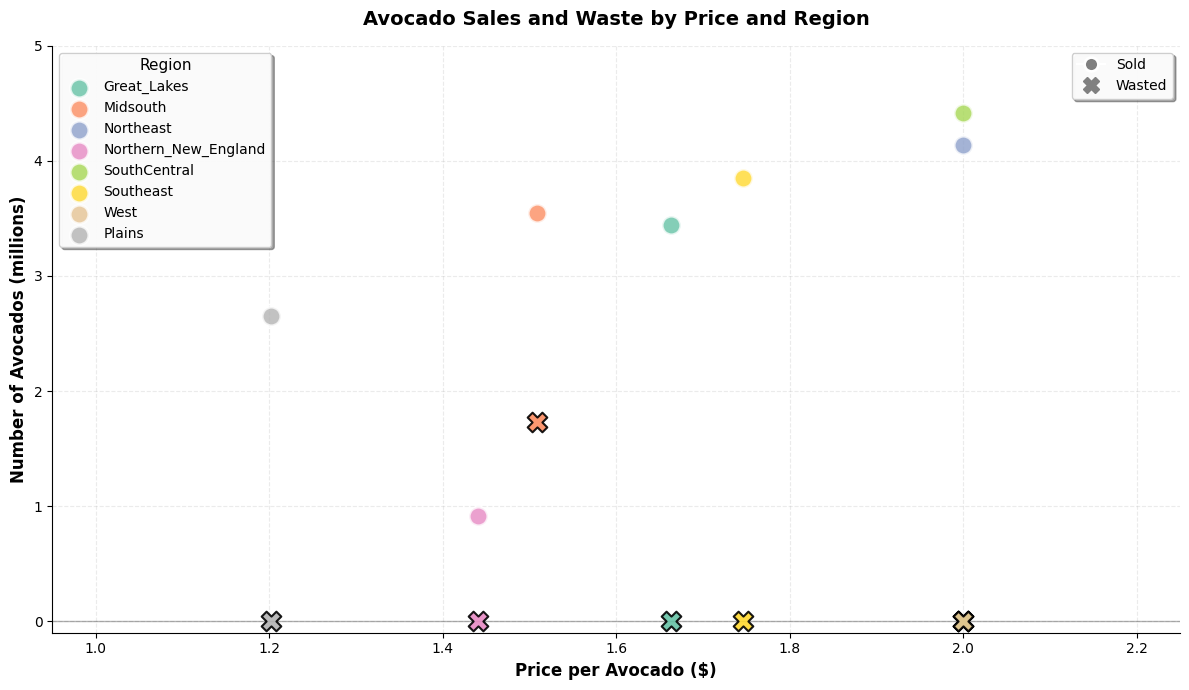

In [117]:
fig, ax = plt.subplots(figsize=(12, 7))

# Get unique regions and set up colors
regions = solution['Region'].unique()
colors = sns.color_palette('Set2', len(regions))

# Plot for each region
for i, region in enumerate(regions):
    region_data = solution[solution['Region'] == region]
    
    # Sold - circles
    ax.scatter(region_data['Price'], region_data['Sold'], 
              s=180, alpha=0.8, color=colors[i], 
              edgecolors='white', linewidth=2, 
              label=region, zorder=3)
    
    # Wasted - X markers (larger and bolder for visibility)
    ax.scatter(region_data['Price'], region_data['Wasted'], 
              marker='X', s=200, alpha=0.9, color=colors[i], 
              edgecolors='black', linewidth=1.5, zorder=4)

# Labels and styling
ax.set_xlabel('Price per Avocado ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Avocados (millions)', fontsize=12, fontweight='bold')

# Adjust y-axis to start slightly below 0 for better visibility
ax.set_ylim(-0.1, 5)
ax.set_xlim(0.95, 2.25)

# Clean grid
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Add horizontal line at y=0 for reference
ax.axhline(y=0, color='black', linewidth=1, alpha=0.3)

# Legend for regions
legend1 = ax.legend(title='Region', loc='upper left', 
                    framealpha=0.95, fontsize=10, 
                    title_fontsize=11, shadow=True)

# Add marker legend
from matplotlib.lines import Line2D
marker_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=10, label='Sold', markeredgecolor='white', markeredgewidth=2),
    Line2D([0], [0], marker='X', color='gray', markersize=11, 
           label='Wasted', linewidth=1.5, linestyle='')
]
legend2 = ax.legend(handles=marker_legend, loc='upper right', 
                    framealpha=0.95, fontsize=10, shadow=True)
ax.add_artist(legend1)

# Title
plt.title('Avocado Sales and Waste by Price and Region', 
         fontsize=14, fontweight='bold', pad=15)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()